Estrategia de Pricing.

Una empresa que distribuye un producto, en diferentes zonas, quiere maximizar sus ingresos aplicando una estrategia de precios diferenciados. Hara esto con una discriminación de precios diferenciada

Importing libraries

In [51]:
import numpy as np
import pandas as pd
import pyodbc as odbc
from matplotlib import pyplot as plt
import seaborn as sns
from skimpy import skim
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
import datetime
import plotly
from plotly import tools
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from IPython.display import HTML, Image
sns.set()
pd.options.display.max_columns = None

Importinfg the dataset from SQL Server

In [52]:
################Connecting to SQL Server#######################

SERVER = 'TroccoPC\TROCCOSERVER'
DATABASE = 'CONTOSO_SALES'
USERNAME = '<username>'
PASSWORD = '<password>'


cnxn = odbc.connect('Driver={SQL Server};'
                      'Server='+SERVER+';'
                      'Database='+DATABASE+';'
                      'Trusted_Connection=yes;')

cursor = cnxn.cursor()

df = pd.read_sql_query ('''
select a.orderid as order_id,
        a.datekey as date,
        b.channelname as channel,
        a.salesquantity,
        c.UnitPrice,
        c.UnitCost,
        a.salesquantity*c.UnitPrice as Income,
        a.salesquantity*c.UnitCost as Devolution,
        (a.salesquantity*c.UnitPrice)-(a.salesquantity*c.UnitCost) as NetIncome,
        c.ClassName,
        c.ProductName,
        c.Manufacturer,
        c.ColorName,
        c.Size
from dbo.FactSales a
left join dbo.DimChannel b
on a.channelkey = b.channelkey
left join dbo.DimProduct c
on a.ProductKey = c.ProductKey''',
cnxn)

cursor.close()
cnxn.close()

C:\Users\asus\AppData\Local\Temp\ipykernel_28776\373877998.py:16: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [53]:
df['date'] = pd.to_datetime(df['date'])
df.describe()

,order_id,date,salesquantity,UnitPrice,UnitCost,Income,Devolution,NetIncome
count,4.564964e+06,4564964,4.564964e+06,4.564964e+06,4.564964e+06,4.564964e+06,4.564964e+06,4.564964e+06
mean,1.703424e+06,2008-05-04 10:28:52.890424832,1.616679e+01,2.971792e+02,1.245984e+02,3.709969e+03,1.572184e+03,2.137786e+03
min,1.000000e+00,2007-01-01 00:00:00,4.000000e+00,9.500000e-01,4.800000e-01,3.800000e+00,1.920000e+00,1.880000e+00
25%,8.518090e+05,2007-07-31 00:00:00,9.000000e+00,6.600000e+01,3.058000e+01,6.720000e+02,3.222400e+02,3.484000e+02
50%,1.704424e+06,2008-03-29 00:00:00,1.000000e+01,2.000000e+02,8.737000e+01,2.322000e+03,9.932400e+02,1.292000e+03
75%,2.554565e+06,2009-01-23 00:00:00,1.300000e+01,3.580000e+02,1.626400e+02,4.788000e+03,2.080080e+03,2.588320e+03
max,3.406089e+06,2009-12-31 00:00:00,2.880000e+03,2.899990e+03,9.608200e+02,2.386800e+05,8.411520e+04,1.596005e+05
std,9.831529e+05,NaN,3.935029e+01,3.473084e+02,1.267488e+02,4.923358e+03,1.906798e+03,3.094012e+03


In [54]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 4564964 │ │ string      │ 6     │                                                         │
│ │ Number of columns │ 14      │ │ float64     │ 5     │                                                         │
│ └───────────────────┴─────────┘ │ int32       │ 2     │                                                         │
│                                 │ datetime64  │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0    ┃ p25    ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ order_id        │   0 │     0 │  1700000 │  980000 │     1 │ 850000 │ 1700000 │ 2600000 │ 3400000 │ ▇▇▇▇▇▇ │  │
│ │ salesquantity   │   0 │     0 │       16 │      39 │     4 │      9 │      10 │      13 │    2900 │   ▇    │  │
│ │ UnitPrice       │   0 │     0 │      300 │     350 │  0.95 │     66 │     200 │     360 │    2900 │   ▇▁   │  │
│ │ UnitCost        │   0 │     0 │      120 │     130 │  0.48 │     31 │      87 │     160 │     960 │  ▇▂▁   │  │
│ │ Income          │   0 │     0 │     3700 │    4900 │   3.8 │    670 │    2300 │    4800 │  240000 │   ▇    │  │
│ │ Devolution      │   0 │     0 │     1600 │    1900 │   1.9 │    320 │     990 │    2100 │   84000 │   ▇    │  │
│ │ NetIncome       │   0 │     0 │     2100 │    3100 │   1.9 │    350 │    1300 │    2600 │  160000 │   ▇    │  │
│ └─────────────────┴─────┴───────┴──────────┴─────────┴───────┴────────┴─────────┴─────────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ date                   │      0 │         0 │     2007-01-01      │     2009-12-31      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA             ┃ NA %        ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ channel                  │              0 │           0 │                         1 │              4564964 │  │
│ │ ClassName                │              0 │           0 │                         1 │              4564964 │  │
│ │ ProductName              │              0 │         

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4564964 entries, 0 to 4564963
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   order_id       int64         
 1   date           datetime64[ns]
 2   channel        object        
 3   salesquantity  int64         
 4   UnitPrice      float64       
 5   UnitCost       float64       
 6   Income         float64       
 7   Devolution     float64       
 8   NetIncome      float64       
 9   ClassName      object        
 10  ProductName    object        
 11  Manufacturer   object        
 12  ColorName      object        
 13  Size           object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(6)
memory usage: 487.6+ MB


In [56]:
df.head()

,order_id,date,channel,salesquantity,UnitPrice,UnitCost,Income,Devolution,NetIncome,ClassName,ProductName,Manufacturer,ColorName,Size
0,1190868,2007-07-21,Store,6,69.00,35.18,414.00,211.08,202.92,Economy,SV 8xDVD E100 Silver,Southridge Video,Silver,None
1,1190871,2008-04-15,Reseller,20,1184.97,392.60,23699.40,7852.00,15847.40,Regular,"Adventure Works 40"" LCD HDTV M690 White",Adventure Works,White,None
2,1190872,2009-07-18,Store,12,850.00,390.88,10200.00,4690.56,5509.44,Regular,"Fabrikam Business Videographer 2/3"" 17mm M280 ...","Fabrikam, Inc.",Orange,5.8 x 7.8 x 1.7
3,1190873,2007-01-02,Store,9,279.99,128.76,2519.91,1158.84,1361.07,Regular,"Adventure Works 19"" Portable LCD HDTV M110 Black",Adventure Works,Black,None
4,1190875,2007-06-05,Online,10,35.99,16.55,359.90,165.50,194.40,Regular,Contoso 2-Line Speakerphone M109 Grey,"Contoso, Ltd",Grey,3.5 x 9 x 4.5


EDA

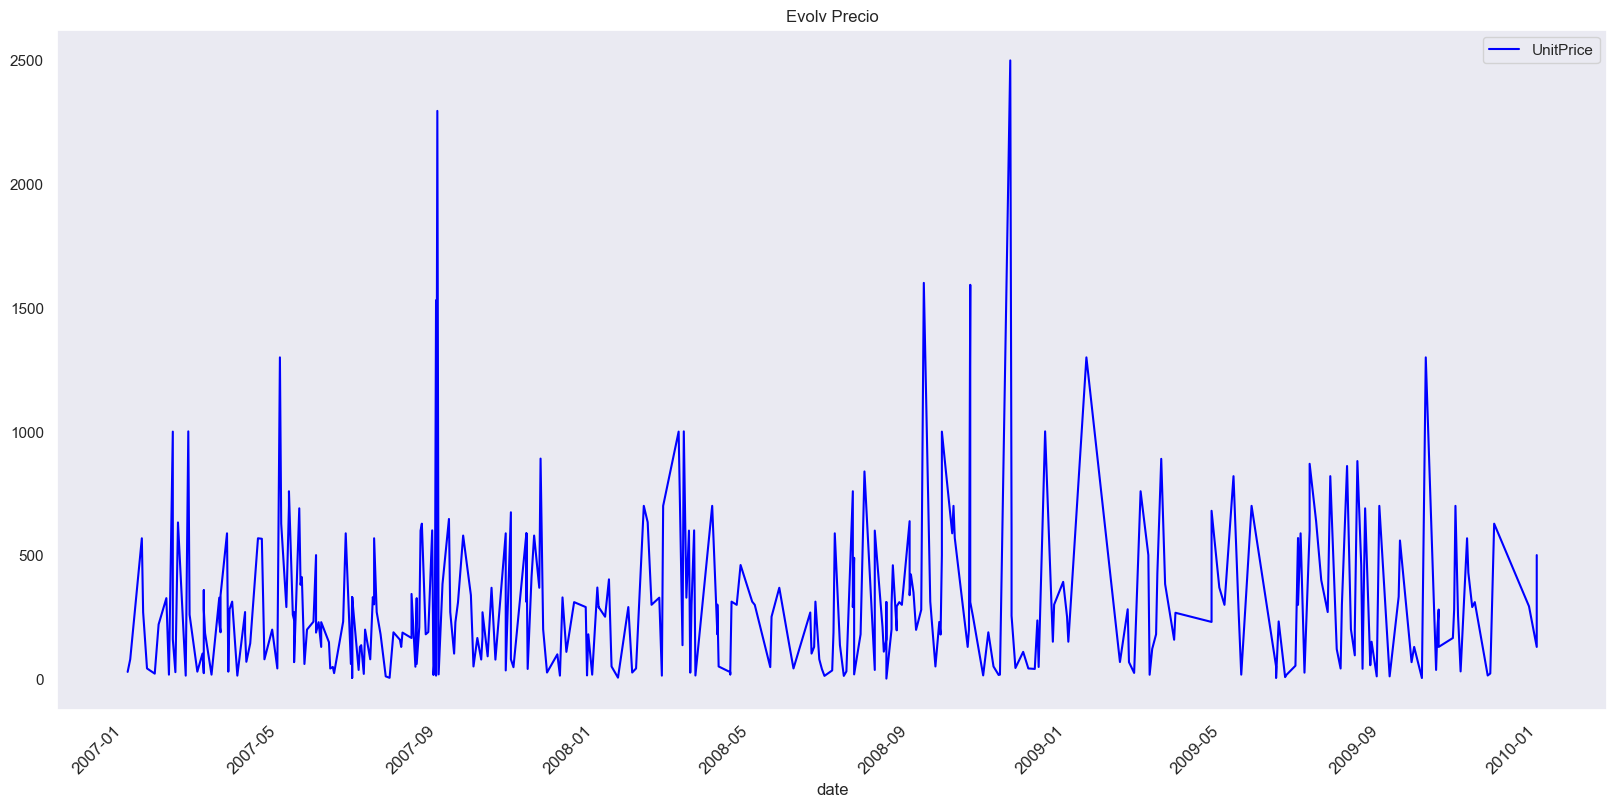

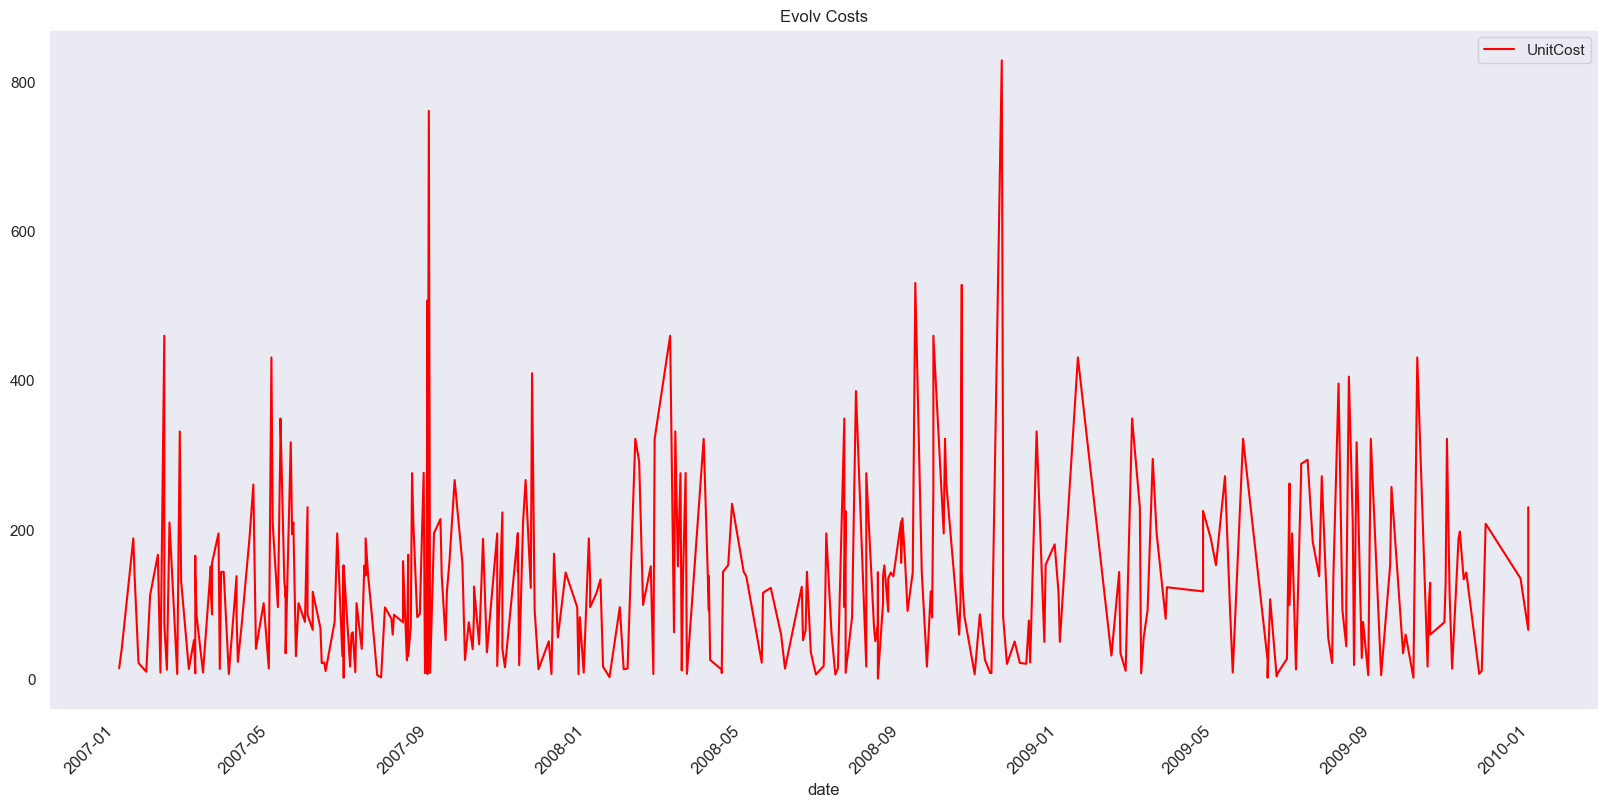

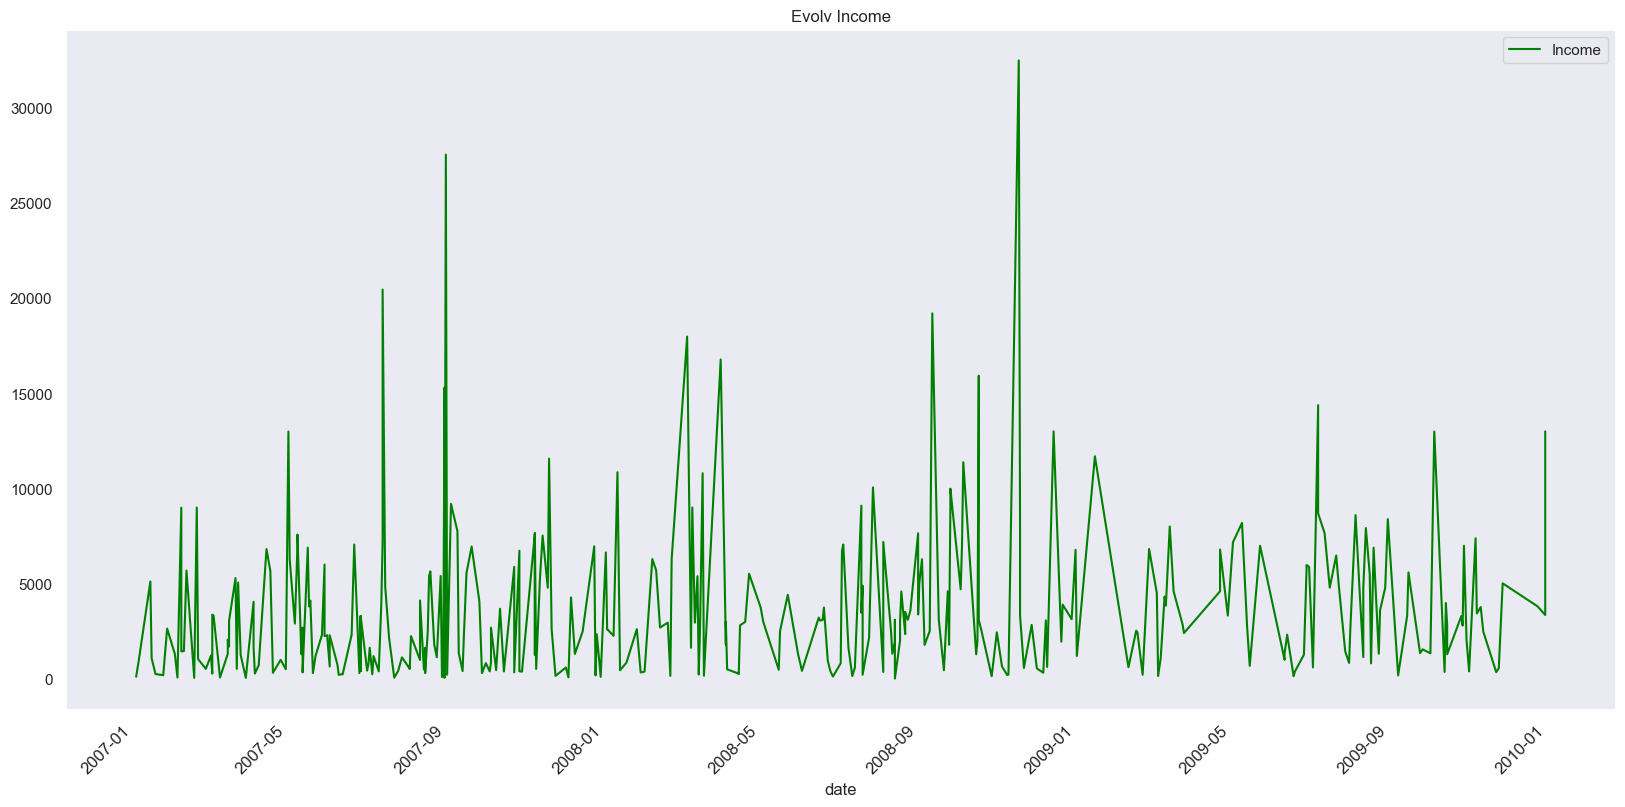

In [57]:
# fix, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex= True)

# df.set_index('date')['UnitPrice'][-(140*3):].plot(ax=axes[0],color = 'blue')
# axes[0].set_title('evolv precio'),
# axes[0].set_ylabel('Precio'),
# axes[0].legend()
# plt.show()

plt.figure(figsize=(20,10))
plt.title('Evolv Precio')
df.set_index('date')['UnitPrice'][-(140*3):].plot(color = 'blue')
plt.xticks(fontsize = 12, rotation= 45)
plt.legend()
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Evolv Costs')
df.set_index('date')['UnitCost'][-(140*3):].plot(color = 'red')
plt.xticks(fontsize = 12, rotation= 45)
plt.legend()
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Evolv Income')
df.set_index('date')['Income'][-(140*3):].plot(color = 'green')
plt.xticks(fontsize = 12, rotation= 45)
plt.legend()
plt.grid()

Estacionalidad Semanal

In [58]:
df['day_week'] = df['date'].dt.weekday

In [59]:
df

,order_id,date,channel,salesquantity,UnitPrice,UnitCost,Income,Devolution,NetIncome,ClassName,ProductName,Manufacturer,ColorName,Size,day_week
0,1190868,2007-07-21,Store,6,69.00,35.18,414.00,211.08,202.92,Economy,SV 8xDVD E100 Silver,Southridge Video,Silver,None,5
1,1190871,2008-04-15,Reseller,20,1184.97,392.60,23699.40,7852.00,15847.40,Regular,"Adventure Works 40"" LCD HDTV M690 White",Adventure Works,White,None,1
2,1190872,2009-07-18,Store,12,850.00,390.88,10200.00,4690.56,5509.44,Regular,"Fabrikam Business Videographer 2/3"" 17mm M280 ...","Fabrikam, Inc.",Orange,5.8 x 7.8 x 1.7,5
3,1190873,2007-01-02,Store,9,279.99,128.76,2519.91,1158.84,1361.07,Regular,"Adventure Works 19"" Portable LCD HDTV M110 Black",Adventure Works,Black,None,1
4,1190875,2007-06-05,Online,10,35.99,16.55,359.90,165.50,194.40,Regular,Contoso 2-Line Speakerphone M109 Grey,"Contoso, Ltd",Grey,3.5 x 9 x 4.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564959,3218608,2009-07-04,Store,24,24.99,12.74,599.76,305.76,294.00,Economy,Contoso Mini Battery Charger Kit E320 Red,"Contoso, Ltd",Red,7.5 x 4 x 4,5
4564960,3218609,2007-07-19,Store,12,179.99,82.77,2159.88,993.24,1166.64,Regular,SV DVD 12-Inch Player Portable M400 Silver,Southridge Video,Silver,7.1 x 6.2 x 1.2,3
4564961,3218610,2007-03-17,Catalog,9,338.00,155.43,3042.00,1398.87,1643.13,Regular,"A. Datum SLR Camera 35"" M358 Silver Grey",A. Datum Corporation,Silver Grey,4 x 2.5 x 5.5,5
4564962,3218611,2008-03-12,Online,9,328.00,150.84,2952.00,1357.56,1594.44,Economy,"Fabrikam SLR Camera 35"" M358 Grey","Fabrikam, Inc.",Grey,3.45 x 4.8 x 3.3,2


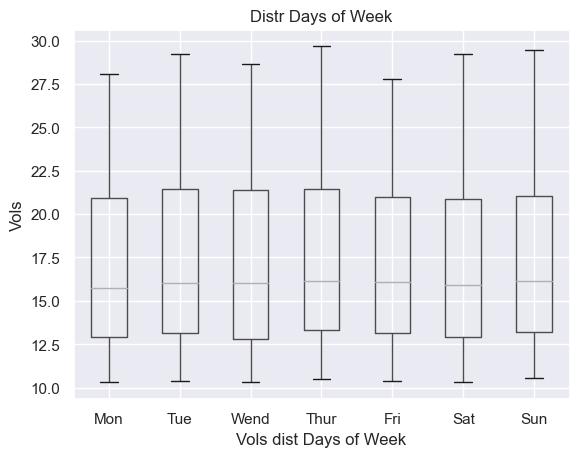

In [60]:
df.pivot_table(index='date',
               columns='day_week',
               values='salesquantity').boxplot()
days_of_week = ['Mon','Tue','Wend','Thur','Fri','Sat','Sun']
plt.xticks(ticks=range(1, len(days_of_week)+1), labels=days_of_week)


plt.xlabel('Vols dist Days of Week')
plt.ylabel('Vols')
plt.title('Distr Days of Week')
plt.show()

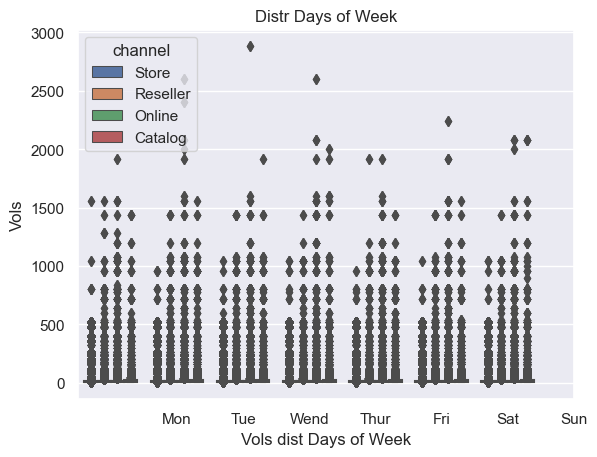

In [61]:
sns.boxplot(data=df, 
            x='day_week',
            y='salesquantity',
             hue='channel' )

plt.xticks(ticks=range(1, len(days_of_week)+1), labels=days_of_week)
plt.xlabel('Vols dist Days of Week')
plt.ylabel('Vols')
plt.title('Distr Days of Week')
plt.show()

In [62]:
Weekly_data = df.pivot_table(index='date',
               columns='channel',
               values='salesquantity').reset_index()
Weekly_data_P = df.pivot_table(index='date',
               columns='channel',
               values='UnitPrice').reset_index()

Weekly_data['weeknum'] = ((Weekly_data['date'] - Weekly_data['date'].min()).dt.days//7)
Weekly_data_P['weeknum'] = ((Weekly_data_P['date'] - Weekly_data_P['date'].min()).dt.days//7)

In [63]:
df_f = pd.merge(left=Weekly_data,
                right= Weekly_data_P,
                left_on= ['date','weeknum'],
                right_on= ['date','weeknum'])

In [64]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1096 non-null   datetime64[ns]
 1   Catalog_x   1096 non-null   float64       
 2   Online_x    1096 non-null   float64       
 3   Reseller_x  1096 non-null   float64       
 4   Store_x     1096 non-null   float64       
 5   weeknum     1096 non-null   int64         
 6   Catalog_y   1096 non-null   float64       
 7   Online_y    1096 non-null   float64       
 8   Reseller_y  1096 non-null   float64       
 9   Store_y     1096 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 85.8 KB


In [65]:
Weekly_data['weeknum'] = ((Weekly_data['date'] - Weekly_data['date'].min()).dt.days//7)

In [66]:
Weekly_data = df_f.groupby('weeknum').agg(
    #Catalog_quantity = ('Catalog_x','sum'),
    #Catalog_price = ('Catalog_y','sum'),
    #Reseller_quantity = ('Reseller_x','sum'),
    #Reseller_price = ('Reseller_x','sum'),
    Online_quantity = ('Online_x','sum'),
    Online_price = ('Online_y','sum'),
).reset_index()

In [67]:
Weekly_data

,weeknum,Online_quantity,Online_price
0,0,90.426343,1670.014307
1,1,91.540309,1826.662144
2,2,92.702280,1774.704346
3,3,89.794014,1737.227422
4,4,94.956500,1720.587703
...,...,...,...
152,152,228.434801,2315.441574
153,153,210.654971,2202.005788
154,154,229.125386,2256.215487
155,155,198.600331,2195.181621


In [68]:
days_of_week_melt = Weekly_data.melt(id_vars=['weeknum','Online_quantity'])
days_of_week_melt.rename(columns={'variable':'channel','value':'precio'},inplace=True)
days_of_week_melt

,weeknum,Online_quantity,channel,precio
0,0,90.426343,Online_price,1670.014307
1,1,91.540309,Online_price,1826.662144
2,2,92.702280,Online_price,1774.704346
3,3,89.794014,Online_price,1737.227422
4,4,94.956500,Online_price,1720.587703
...,...,...,...,...
152,152,228.434801,Online_price,2315.441574
153,153,210.654971,Online_price,2202.005788
154,154,229.125386,Online_price,2256.215487
155,155,198.600331,Online_price,2195.181621


In [69]:
elast_var = smf.ols(formula='Online_quantity ~ precio',data= days_of_week_melt).fit()

In [70]:
print(elast_var.summary())

                            OLS Regression Results                            
Dep. Variable:        Online_quantity   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     235.6
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           6.34e-33
Time:                        22:04:44   Log-Likelihood:                -726.01
No. Observations:                 157   AIC:                             1456.
Df Residuals:                     155   BIC:                             1462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -286.8106     28.447    -10.082      0.0

In [71]:
elast_cte = smf.ols(formula='np.log(Online_quantity) ~ np.log(precio)',data= days_of_week_melt).fit()

In [72]:
print(elast_cte.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log(Online_quantity)   R-squared:                       0.575
Model:                                 OLS   Adj. R-squared:                  0.572
Method:                      Least Squares   F-statistic:                     209.3
Date:                     Wed, 12 Mar 2025   Prob (F-statistic):           1.45e-30
Time:                             22:04:44   Log-Likelihood:                 55.157
No. Observations:                      157   AIC:                            -106.3
Df Residuals:                          155   BIC:                            -100.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [73]:
r2_linear = elast_var.rsquared
r2_loglog = elast_cte.rsquared

In [74]:
range_price = np.arange(0,2999,1)
price_data = pd.DataFrame({'precio':range_price})
price_data['elast_var']= elast_var.predict(price_data)
price_data['elast_cte']= np.exp(elast_cte.predict(price_data))
price_data.sort_values('precio',inplace=True)

c:\Users\asus\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



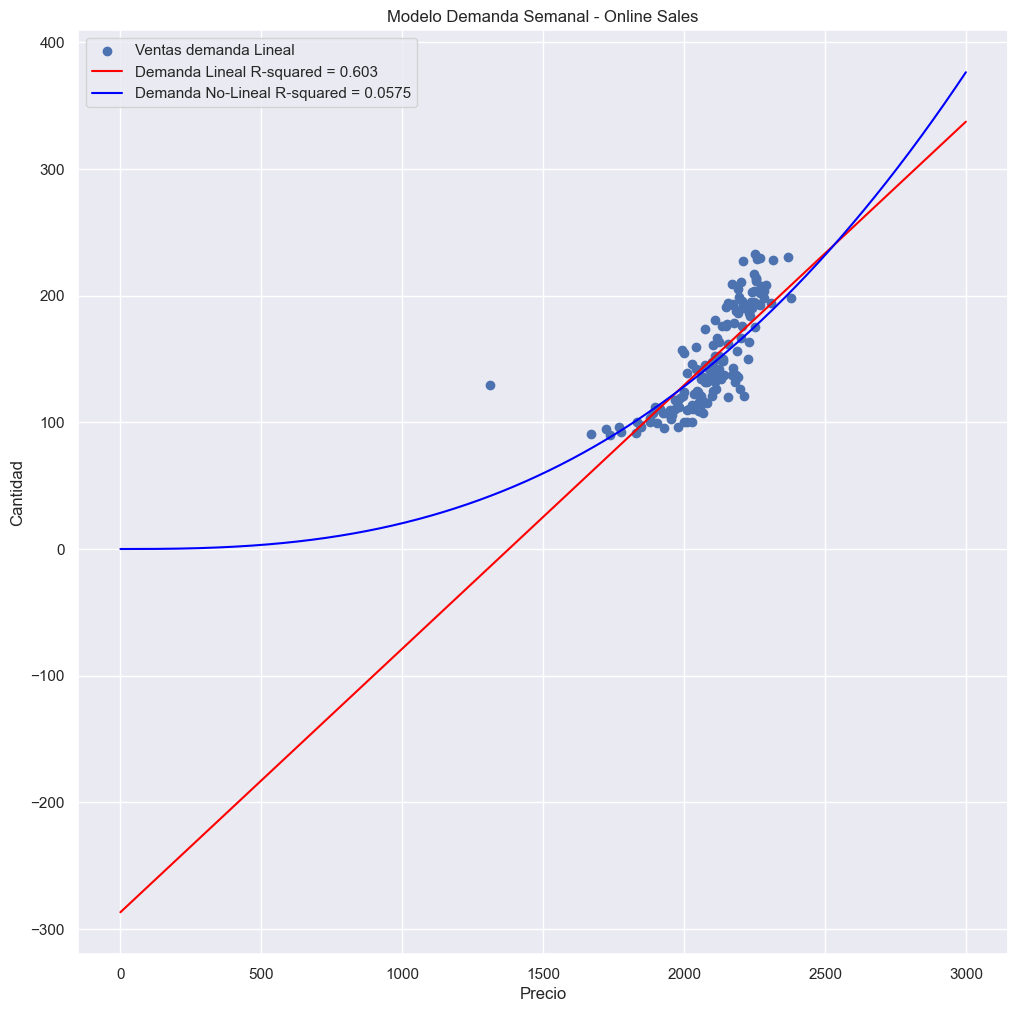

In [75]:
plt.figure(figsize=(12,12))
plt.scatter(days_of_week_melt['precio'],days_of_week_melt['Online_quantity'], label = 'Ventas demanda Lineal')
plt.plot(price_data['precio'], price_data['elast_var'], color = 'red', label= f'Demanda Lineal R-squared = 0.603')
plt.plot(price_data['precio'], price_data['elast_cte'], color = 'blue', label= f'Demanda No-Lineal R-squared = 0.0575')
plt.xlabel('Precio')
plt.ylabel('Cantidad')
plt.title('Modelo Demanda Semanal - Online Sales')
plt.legend()
plt.show()

In [76]:
range_price_df = pd.DataFrame({'precio': range_price})
predicted_quantity = elast_var.predict(range_price_df)

range_price_df['elasticity_total'] = elast_var.params['precio']*(range_price_df['precio'] / predicted_quantity)

In [77]:
closest_to_zero_index = (range_price_df['elasticity_total']+1).abs().idxmin()

closest_price = range_price_df.loc[closest_to_zero_index,'precio']
closest_elasticity = range_price_df.loc[closest_to_zero_index,'elasticity_total']

print(f'El precio mas cercano  a elasticidad 1 es {closest_price:.2f} con una elasticidad de {closest_elasticity:.4f}')

El precio mas cercano  a elasticidad 1 es 689.00 con una elasticidad de -1.0007


In [78]:
cte_elasticity = elast_cte.params['np.log(precio)']
print(f"elasticidad constante del modelo es: {cte_elasticity:.2f}")

elasticidad constante del modelo es: 2.66


In [79]:
elasticity_lin = elast_var.params['precio']
print(f"elasticidad constante del modelo es: {cte_elasticity:.2f}")

elasticidad constante del modelo es: 2.66


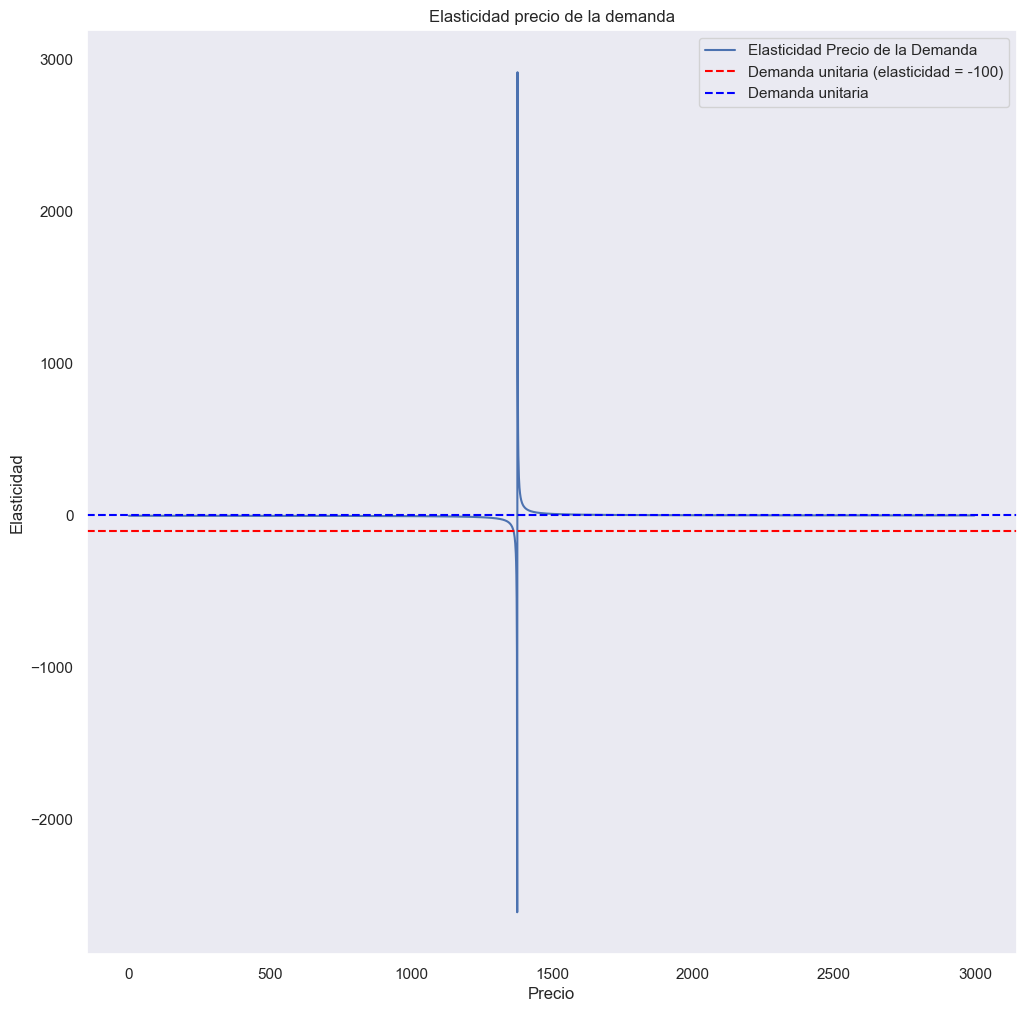

In [80]:
plt.figure(figsize=(12,12))
plt.plot(range_price,
         range_price_df['elasticity_total'],
         label='Elasticidad Precio de la Demanda')
plt.axhline(y=-100,
            color='red',
            linestyle = '--',
            label= f'Demanda unitaria (elasticidad = -100)')
plt.axhline(y=cte_elasticity,
            color='blue',
            linestyle = '--',
            label= f'Demanda unitaria')
plt.title('Elasticidad precio de la demanda')
plt.xlabel('Precio')
plt.ylabel('Elasticidad')
plt.legend()
plt.grid()
plt.show()